<a href="https://colab.research.google.com/github/Vmjkom/Projektit/blob/master/BoW_and_LSTM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!wget -nc http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
!wget -nc http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
!wget -nc http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-train.tsv

File ‘fincore-dev.tsv’ already there; not retrieving.

File ‘fincore-test.tsv’ already there; not retrieving.

File ‘fincore-train.tsv’ already there; not retrieving.



Data is transformed to panda's dataframe, because thats what i thought to be simplest to handle. 

,Labels,Text
3696,DF ID,Jaa miks näin ? Mulla ainakin vaikeuksia saad...
277,NE NA,Juuri nyt Stockmannin liikevaihto huhti-kesäk...
1600,DS IG,Pietari Pietari on Venäjän toiseksi suurin- j...
1479,NE NA,Poliisi tutkii varastetuilla verkkopankkitunn...
4240,DS IG,Hakulomake Etsi Safera Oy - Lisää turvaa koti...


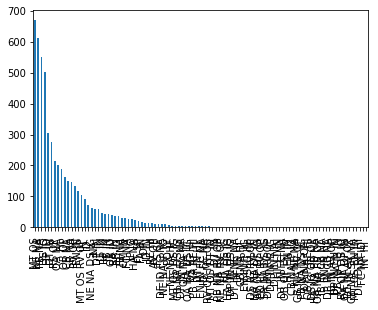

In [113]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

train_df = pd.read_csv('/content/fincore-train.tsv',delimiter = '\t',names=['Labels', 'Text'])
train_df = shuffle(train_df)

dev_df = pd.read_csv('/content/fincore-dev.tsv',delimiter = '\t',names=['Labels', 'Text'])
dev_df = shuffle(dev_df)

test_df = pd.read_csv('/content/fincore-test.tsv',delimiter = '\t',names=['Labels', 'Text'])
test_df = shuffle(test_df)


train_df.Labels.value_counts().plot(kind='bar');
train_df.head()


**Text needs cleaning up and labels are transformed to their respective main register classes. **

In [0]:
import string

def clean_label(label):
  label = label.strip()
  label = label[-2:]
  return label

def clean_text(text):
  text = text.lower()
  text = text.strip()
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

     Labels                                               Text
3696     ID  jaa miks näin  mulla ainakin vaikeuksia saada ...
277      NA  juuri nyt stockmannin liikevaihto huhtikesäkuu...
1600     IG  pietari pietari on venäjän toiseksi suurin ja ...
1479     NA  poliisi tutkii varastetuilla verkkopankkitunnu...
4240     IG  hakulomake etsi safera oy  lisää turvaa kotiin...
    Labels                                               Text
10      NA  kiitoksia lähettämistä runoistasi  jotka taase...
114     NA  projekteja  kauhajoen lukio oli lähtenyt 1996 ...
644     ID  katsoin norjalaisen dagbladetin artikkelia ja ...
698     HI  osakekauppa on helppoa internetin välityksellä...
427     IN  emmental emmental   eli tahkojuusto on puoliko...


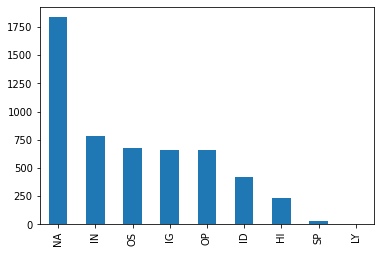

In [115]:
train_df['Labels'] = train_df['Labels'].apply(clean_label)
train_df['Text'] = train_df['Text'].apply(clean_text)

train_df.head()

dev_df['Labels'] = dev_df['Labels'].apply(clean_label)
dev_df['Text'] = dev_df['Text'].apply(clean_text)

dev_df.head()

test_df['Labels'] = test_df['Labels'].apply(clean_label)
test_df['Text'] = test_df['Text'].apply(clean_text)

train_df.Labels.value_counts().plot(kind='bar');
print(train_df.head())
print(dev_df.head())





TfidfVectorizer for feature matrixes and labelencoder for the labels. 

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


tfidf = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,2),min_df=5)
label_encoder=LabelEncoder()

train_features = tfidf.fit_transform(train_df.Text)
train_labels = label_encoder.fit_transform(train_df.Labels)

dev_features = tfidf.transform(dev_df.Text)
dev_labels = label_encoder.transform(dev_df.Labels)

test_features = tfidf.transform(test_df.Text)
test_labels = label_encoder.transform(test_df.Labels)

print(train_features.shape)
print("class labels",label_encoder.classes_)



(5295, 90457)
class labels ['HI' 'ID' 'IG' 'IN' 'LY' 'NA' 'OP' 'OS' 'SP']


**Simple sequential model. Experimented a little with different node amounts on the first layer, 100 seems to be good.**

In [0]:
import keras
from keras.models import Sequential
from keras import layers

input_dim = train_features.shape[1]
class_count = len(label_encoder.classes_)

model=Sequential()
model.add(layers.Dense(100,input_dim=input_dim,activation='relu'))
model.add(layers.Dense(class_count,activation='softmax'))



**9 different classes so decided to go for sparse categorical crossentropy. **

In [118]:
from keras.callbacks import EarlyStopping

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'] )
model.summary()

callbacks = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 100)               9045800   
_________________________________________________________________
dense_59 (Dense)             (None, 9)                 909       
Total params: 9,046,709
Trainable params: 9,046,709
Non-trainable params: 0
_________________________________________________________________


**Decent parameters, will experiment more below.**

In [119]:
history=model.fit(train_features,train_labels,epochs=10,batch_size=50,validation_data=(dev_features,dev_labels))

Train on 5295 samples, validate on 756 samples
Epoch 1/10
5295/5295 [==============================] - 17s 3ms/step - loss: 1.5841 - accuracy: 0.5260 - val_loss: 1.1570 - val_accuracy: 0.6071
Epoch 2/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.7465 - accuracy: 0.8045 - val_loss: 0.9270 - val_accuracy: 0.7090
Epoch 3/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.3011 - accuracy: 0.9688 - val_loss: 0.8591 - val_accuracy: 0.7169
Epoch 4/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.1097 - accuracy: 0.9923 - val_loss: 0.8410 - val_accuracy: 0.7249
Epoch 5/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.0523 - accuracy: 0.9955 - val_loss: 0.8448 - val_accuracy: 0.7235
Epoch 6/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.0317 - accuracy: 0.9962 - val_loss: 0.8469 - val_accuracy: 0.7275
Epoch 7/10
5295/5295 [==============================] - 17s 3ms/step - loss: 0.0234

**As we can see accuracy seems to improve very slowly after 2nd Epoch, but decent enough accuracy at 72% with this data in my opinnion.**

In [120]:
print(history.history['val_accuracy'])

[0.6071428656578064, 0.7089946866035461, 0.7169312238693237, 0.7248677015304565, 0.7235449552536011, 0.7275132536888123, 0.7248677015304565, 0.7208994626998901, 0.7195767164230347, 0.726190447807312]


In [121]:
model_2=Sequential()
model_2.add(layers.Dense(200,input_dim=input_dim,activation='relu'))
model_2.add(layers.Dense(class_count,activation='softmax'))

model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

history_2 = model_2.fit(train_features,train_labels,epochs=10,batch_size=50,validation_data=(dev_features,dev_labels))

Train on 5295 samples, validate on 756 samples
Epoch 1/10
5295/5295 [==============================] - 25s 5ms/step - loss: 1.4264 - accuracy: 0.5509 - val_loss: 1.0630 - val_accuracy: 0.6786
Epoch 2/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.6835 - accuracy: 0.8247 - val_loss: 0.8853 - val_accuracy: 0.7288
Epoch 3/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.3049 - accuracy: 0.9520 - val_loss: 0.8295 - val_accuracy: 0.7394
Epoch 4/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.1205 - accuracy: 0.9838 - val_loss: 0.8386 - val_accuracy: 0.7196
Epoch 5/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.0497 - accuracy: 0.9932 - val_loss: 0.8838 - val_accuracy: 0.7103
Epoch 6/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.0242 - accuracy: 0.9970 - val_loss: 0.9463 - val_accuracy: 0.7196
Epoch 7/10
5295/5295 [==============================] - 24s 5ms/step - loss: 0.0171

Changing the Dense units and model optimizer seems to have no effect at all.

In [122]:
model_3=Sequential()
model_3.add(layers.Dense(10,input_dim=input_dim,activation='relu'))
model_3.add(layers.Dense(class_count,activation='softmax'))

model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

history_3 = model_3.fit(train_features,train_labels,epochs=10,batch_size=20,validation_data=(dev_features,dev_labels))

Train on 5295 samples, validate on 756 samples
Epoch 1/10
5295/5295 [==============================] - 7s 1ms/step - loss: 1.7626 - accuracy: 0.4045 - val_loss: 1.4080 - val_accuracy: 0.5212
Epoch 2/10
5295/5295 [==============================] - 7s 1ms/step - loss: 1.1111 - accuracy: 0.6002 - val_loss: 1.1169 - val_accuracy: 0.6005
Epoch 3/10
5295/5295 [==============================] - 7s 1ms/step - loss: 0.7336 - accuracy: 0.7977 - val_loss: 0.9951 - val_accuracy: 0.6680
Epoch 4/10
5295/5295 [==============================] - 7s 1ms/step - loss: 0.4604 - accuracy: 0.9296 - val_loss: 0.9304 - val_accuracy: 0.7050
Epoch 5/10
5295/5295 [==============================] - 7s 1ms/step - loss: 0.2776 - accuracy: 0.9790 - val_loss: 0.9012 - val_accuracy: 0.7024
Epoch 6/10
5295/5295 [==============================] - 7s 1ms/step - loss: 0.1708 - accuracy: 0.9879 - val_loss: 0.8863 - val_accuracy: 0.7011
Epoch 7/10
5295/5295 [==============================] - 7s 1ms/step - loss: 0.1118 - accu

**Still no change, dont know why. Time to see how it does with unseen test data**

In [123]:
history_test = model.evaluate(test_features,test_labels)
print(history_test)

1513/1513 [==============================] - 1s 815us/step
[0.930460403001789, 0.6807667016983032]


# Milestone 1.2 RNN LSTM

In [124]:
from tensorflow.keras.preprocessing.text import Tokenizer

#Combine train and development dataframes so its easier for me to code

combine = [train_df,dev_df]
frames = pd.concat(combine)



tokenizer = Tokenizer( num_words=10000)
label_tokenizer = Tokenizer()

tokenizer.fit_on_texts(frames['Text'])
labels= label_tokenizer.fit_on_texts(frames['Labels'])

word_index = tokenizer.word_index
print(len(word_index))
frames.head()

432486


,Labels,Text
3696,ID,jaa miks näin mulla ainakin vaikeuksia saada ...
277,NA,juuri nyt stockmannin liikevaihto huhtikesäkuu...
1600,IG,pietari pietari on venäjän toiseksi suurin ja ...
1479,NA,poliisi tutkii varastetuilla verkkopankkitunnu...
4240,IG,hakulomake etsi safera oy lisää turvaa kotiin...


Here we tokenized the texts, didnt bother using tokenizer parameters much because text has arleady been cleaned up quite well in earlier bag of words classifier.

In [125]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


sequences = tokenizer.texts_to_sequences(frames['Text'])
padded = pad_sequences(sequences,maxlen=200)
print(len(sequences))
print(padded.shape)


labels = pd.get_dummies(frames['Labels'])
print(labels.shape)
print()
print(padded[0])

6051
(6051, 200)
(6051, 9)

[2201 2202   35  326   77  385    2   23  218  415   16 1303  153  547
  957   42   23  787   31 1474   32    1  408 8280    2 2209  710    2
 9379    1    3   60    1   23  781   16  619  554  857    1 3267  781
 8628   71  236 5095   16 1251 5227    1 3706 1717 4640 8448 3194 1271
 9799    7    4 1270 8107  283    8 3894    1 2567  274   66    3 5095
    1 5227  256   79 5023  787  134  127 1164   23   29    1   35  326
    8 1031  142  680  220  366    9    7  792 5651  101  217 4817   23
    6    2  125   64 2139   32 1223 2221  108 3370  908    1  396   71
  908 1278  675 1809 1501    1 1001 1591 9594   13 1289  251 1426  865
 2568 9595  404    1 1405   55 1621   64  216    8  101    1 3371    2
  619    3    8    3  198  115    3   41   14  300   15   43 3894    2
 1684  300   71   51    8    9 8800  421    1  344   13 3016    3   64
  144    8  878  209  967   13    1 8449   40    4   97    2  565   46
    1  300    4 3016    8  801 8450 1019  297 917

Padded sequences with 200 max length and default parameters. Quite alot of zeros.

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(padded,labels, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4840, 200) (4840, 9)
(1211, 200) (1211, 9)


In [127]:
from keras.layers import LSTM, Embedding


model_lstm = Sequential()
model_lstm.add(Embedding(10000,100,input_length=padded.shape[1]))
model_lstm.add(LSTM(100))
model_lstm.add(layers.Dense(9,activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
lstm_52 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_64 (Dense)             (None, 9)                 909       
Total params: 1,081,309
Trainable params: 1,081,309
Non-trainable params: 0
_________________________________________________________________


In [129]:
history_lstm = model_lstm.fit(padded,labels,epochs=5,batch_size=10,validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5445 samples, validate on 606 samples
Epoch 1/5
5445/5445 [==============================] - 83s 15ms/step - loss: 1.5863 - accuracy: 0.4459 - val_loss: 1.5195 - val_accuracy: 0.4455
Epoch 2/5
5445/5445 [==============================] - 82s 15ms/step - loss: 1.0596 - accuracy: 0.6331 - val_loss: 1.4215 - val_accuracy: 0.4868
Epoch 3/5
5445/5445 [==============================] - 82s 15ms/step - loss: 0.5896 - accuracy: 0.8118 - val_loss: 1.4054 - val_accuracy: 0.5611
Epoch 4/5
5445/5445 [==============================] - 81s 15ms/step - loss: 0.2668 - accuracy: 0.9249 - val_loss: 1.7865 - val_accuracy: 0.5066
Epoch 5/5
5445/5445 [==============================] - 82s 15ms/step - loss: 0.1514 - accuracy: 0.9600 - val_loss: 1.9422 - val_accuracy: 0.5396


Pretty bad result from beginning to end. Changing hyperparameters eventhough some problem might lie with the data itself.

In [130]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
from keras.layers import Dropout

combine2 = [train_df,dev_df]
frames2 = pd.concat(combine2)

tokenizer2 = Tokenizer( num_words=vocab_size)
label_tokenizer2 = Tokenizer()

tokenizer2.fit_on_texts(frames2['Text'])
labels2= pd.get_dummies(frames2['Labels'])



sequences2 = tokenizer2.texts_to_sequences(frames2['Text'])
padded2 = pad_sequences(sequences2,maxlen=max_length,padding=padding_type,truncating=trunc_type)
print(padded2.shape)


model2_lstm = Sequential()
model2_lstm.add(Embedding(vocab_size,embedding_dim,input_length=padded2.shape[1]))
model2_lstm.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
model2_lstm.add(layers.Dense(9,activation='softmax'))

model2_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_lstm.summary()

print(padded2[0])

X_train, X_test, Y_train, Y_test = train_test_split(padded2,labels2, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)



(6051, 100)
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 100, 64)           1280000   
_________________________________________________________________
lstm_53 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_65 (Dense)             (None, 9)                 909       
Total params: 1,346,909
Trainable params: 1,346,909
Non-trainable params: 0
_________________________________________________________________
[ 3605  6269    83   710   151  2721   112  8627  9379  1876  1314  2397
   164   355  1085 16777   769    33     3  1501     1   160   603  2139
     2   336   248  4259  3532     2 11934     1  3233    13 17472  2139
  1653  1845  6361     1   127  5226   809   119  3234  2276   781   986
    98  2625  4309   933    71   283  4760    41  5023     9     3   

**Changed embedding layer dimension and changed padding and trunc to 'post.
Also changed max length of the padding to 50 from 200 to limit the amount of 0's. Added dropout to the LSTM layer to limit overfitting**

In [131]:
history_lstm2 = model2_lstm.fit(padded2,labels2,epochs=5,batch_size=10,validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5445 samples, validate on 606 samples
Epoch 1/5
5445/5445 [==============================] - 47s 9ms/step - loss: 1.7717 - accuracy: 0.3640 - val_loss: 1.5957 - val_accuracy: 0.4422
Epoch 2/5
5445/5445 [==============================] - 48s 9ms/step - loss: 1.4008 - accuracy: 0.4929 - val_loss: 1.4270 - val_accuracy: 0.4868
Epoch 3/5
5445/5445 [==============================] - 48s 9ms/step - loss: 1.0311 - accuracy: 0.6305 - val_loss: 1.4163 - val_accuracy: 0.5000
Epoch 4/5
5445/5445 [==============================] - 51s 9ms/step - loss: 0.7322 - accuracy: 0.7471 - val_loss: 1.4967 - val_accuracy: 0.5231
Epoch 5/5
5445/5445 [==============================] - 48s 9ms/step - loss: 0.5095 - accuracy: 0.8296 - val_loss: 1.6841 - val_accuracy: 0.5099


**No improvement, raising batch_size to 20 when fitting.
Lstm units set to 50**

---



In [132]:
model3_lstm = Sequential
vocab_size = 10000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
from keras.layers import Dropout

combine3 = [train_df,dev_df]
frames3 = pd.concat(combine3)

tokenizer3 = Tokenizer( num_words=vocab_size)
label_tokenizer3 = Tokenizer()

tokenizer3.fit_on_texts(frames3['Text'])
labels3= pd.get_dummies(frames3['Labels'])



sequences3 = tokenizer3.texts_to_sequences(frames3['Text'])
padded3 = pad_sequences(sequences3,maxlen=max_length,padding=padding_type,truncating=trunc_type)
print(padded3.shape)

model3_lstm = Sequential()
model3_lstm.add(Embedding(vocab_size,embedding_dim,input_length=padded3.shape[1]))
model3_lstm.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
model3_lstm.add(layers.Dense(9,activation='softmax'))

model3_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_lstm.summary()

print(padded3[0])

X_train, X_test, Y_train, Y_test = train_test_split(padded3,labels3, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6051, 100)
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
lstm_54 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_66 (Dense)             (None, 9)                 459       
Total params: 663,459
Trainable params: 663,459
Non-trainable params: 0
_________________________________________________________________
[3605 6269   83  710  151 2721  112 8627 9379 1876 1314 2397  164  355
 1085  769   33    3 1501    1  160  603 2139    2  336  248 4259 3532
    2    1 3233   13 2139 1653 1845 6361    1  127 5226  809  119 3234
 2276  781  986   98 2625 4309  933   71  283 4760   41 5023    9    3
  601   69 5899 9379   95   79  530   97  769 1955  653 1041  781 3894
   97    9

In [133]:
history_lstm3 = model3_lstm.fit(padded3,labels3,epochs=5,batch_size=20,validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5445 samples, validate on 606 samples
Epoch 1/5
5445/5445 [==============================] - 21s 4ms/step - loss: 1.7815 - accuracy: 0.3658 - val_loss: 1.5896 - val_accuracy: 0.4455
Epoch 2/5
5445/5445 [==============================] - 19s 4ms/step - loss: 1.4851 - accuracy: 0.4711 - val_loss: 1.4430 - val_accuracy: 0.4835
Epoch 3/5
5445/5445 [==============================] - 20s 4ms/step - loss: 1.2411 - accuracy: 0.5352 - val_loss: 1.3842 - val_accuracy: 0.4439
Epoch 4/5
5445/5445 [==============================] - 19s 4ms/step - loss: 1.0375 - accuracy: 0.6184 - val_loss: 1.4294 - val_accuracy: 0.4917
Epoch 5/5
5445/5445 [==============================] - 19s 4ms/step - loss: 0.8782 - accuracy: 0.6876 - val_loss: 1.5116 - val_accuracy: 0.4934


**Original model seems to work the best, but couldnt manage to squeeze out a good accuracy from any of them. **
**Ville Komulainen, Milestone 1**